# K-Means from Scratch

*Necessary Imports*

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

In [3]:
wiki = pd.read_csv("people_wiki.csv")
wiki.head(10)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson>,Sam Henderson,sam henderson born october 18 1969 is an ameri...
6,<http://dbpedia.org/resource/Aaron_LaCrate>,Aaron LaCrate,aaron lacrate is an american music producer re...
7,<http://dbpedia.org/resource/Trevor_Ferguson>,Trevor Ferguson,trevor ferguson aka john farrow born 11 novemb...
8,<http://dbpedia.org/resource/Grant_Nelson>,Grant Nelson,grant nelson born 27 april 1971 in london also...
9,<http://dbpedia.org/resource/Cathy_Caruth>,Cathy Caruth,cathy caruth born 1955 is frank h t rhodes pro...


In [4]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59071 entries, 0 to 59070
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     59071 non-null  object
 1   name    59071 non-null  object
 2   text    59071 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [5]:
wiki.describe(include='all')

,URI,name,text
count,59071,59071,59071
unique,59071,59070,59071
top,<http://dbpedia.org/resource/Guillermo_Galv%C3...,author),teresa surez commonly known by her stage name ...
freq,1,2,1


#### Loading tf-idf

Term Frequency: $ word \ counts $

Inverse Document Frequency: $ log \big{(} \dfrac{no. of \ docs}{1 + no. of \ docs \ using \ word} \big{)} $

In [0]:
data = np.load('data.npy')
indices = np.load('indices.npy')
indptr = np.load('indptr.npy')
shape = np.load('shape.npy')
from scipy.sparse import csr_matrix 
tf_idf = csr_matrix((data, indices, indptr), shape)

In [0]:
import json
with open('people_wiki_map_index_to_word.json', 'r') as f:
    people_wiki_map_index_to_word = json.load(f)
map_index_to_word = people_wiki_map_index_to_word

Normalize all Vectors

$$ ||\mathbf{x}-\mathbf{y}||^2 = (\mathbf{x}-\mathbf{y})^T(\mathbf{x}-\mathbf{y}) = 2[cosine \ distance] $$

In [0]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## K-Means Model

Choose an initial set of centroids, randomly from the data points.

In [0]:
def get_initial_centroids(data, k, seed=None):
    
    if seed is not None: # for obtaining consistent results
        np.random.seed(seed)

    n = data.shape[0]
    rand_indices = np.random.randint(0, n, k)

    centroids = data[rand_indices,:].toarray()    
    return centroids

### Assigning clusters

1. Assign each data point to the closest centroid:
$ z_i = argmin_j ||\mu_j - \mathbf{x}_i||^2 $
2. Revise centroids as the mean of the assigned data points:
$ \mu_j = \frac{1}{n_j} \sum_{i:z_i=j} \mathbf{x_i}$

In [10]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
from sklearn.metrics import pairwise_distances
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


In [11]:
first_3_centroids = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, first_3_centroids, metric='euclidean')
dist = distances[430, 1]
print(dist)

1.4071310658540346


In [12]:
distances = distances.copy()
closest_cluster = np.argmin(distances, axis=1)
print(closest_cluster)
print(closest_cluster.shape)

[0 1 2 ... 0 0 0]
(59071,)


In [0]:
def assign_clusters(data, centroids):
    
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

### Revising clusters

Repeat the the above steps.

In [0]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [15]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


In [16]:
print(cluster_assignment==1)
print(cluster_assignment==0)

[False  True False]
[ True False  True]


In [17]:
print(data[cluster_assignment==1])
print(data[cluster_assignment==0])

[[0. 0. 0.]]
[[1. 2. 0.]
 [2. 2. 0.]]


In [18]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

In [0]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []

    for i in range(k):
        # Select all data points that belong to cluster i
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points
        centroid = member_data_points.mean(axis=0)        
        # Falttern
        centroid = centroid.A1
        new_centroids.append(centroid)

    new_centroids = np.array(new_centroids)    
    return new_centroids

### Assessing convergence

Cluster Heterogeneity: 
$ J(Z,\mu) = \sum_{j=1}^{k} \sum_{i:z_i=j} ||\mathbf{x}_i - \mu_j||^2 $

In [0]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0:
            # Compute distances from centroid to data points
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [21]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

## Combining into a single function

- Repeatedly perform above steps
- Track convergence metrics
- Stop if either no assignment changes or after certain number of iterations

In [0]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):

    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(f"Itr#{itr}:", end=" ")
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points of cluster
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment-cluster_assignment))
            if verbose:
                print(f'{num_changed} elements changed their cluster assignment.')   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting Convergence Metric

Cluster Heterogeneity

In [23]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)

Itr#0: Itr#1: 23983 elements changed their cluster assignment.
Itr#2: 11828 elements changed their cluster assignment.
Itr#3: 7455 elements changed their cluster assignment.
Itr#4: 4785 elements changed their cluster assignment.
Itr#5: 3837 elements changed their cluster assignment.
Itr#6: 4147 elements changed their cluster assignment.
Itr#7: 4587 elements changed their cluster assignment.
Itr#8: 3822 elements changed their cluster assignment.
Itr#9: 1665 elements changed their cluster assignment.
Itr#10: 725 elements changed their cluster assignment.
Itr#11: 368 elements changed their cluster assignment.
Itr#12: 202 elements changed their cluster assignment.
Itr#13: 129 elements changed their cluster assignment.
Itr#14: 95 elements changed their cluster assignment.
Itr#15: 81 elements changed their cluster assignment.
Itr#16: 64 elements changed their cluster assignment.
Itr#17: 58 elements changed their cluster assignment.
Itr#18: 54 elements changed their cluster assignment.
Itr#19

In [0]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(10,6))
    plt.plot(heterogeneity)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Heterogeneity')
    plt.title(f'Heterogeneity of clustering over time, K={k}')

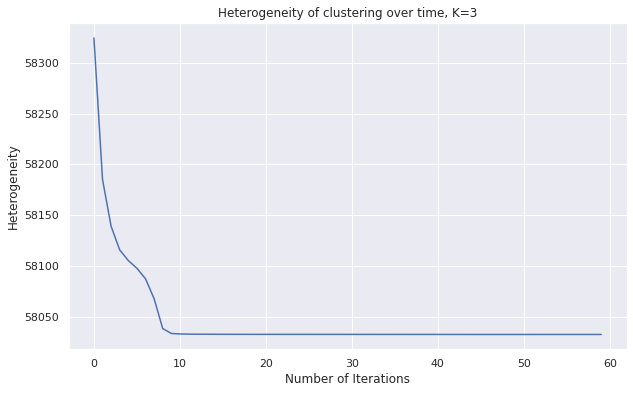

In [25]:
plot_heterogeneity(heterogeneity, k)

In [26]:
print(heterogeneity)

[58324.513557360166, 58184.88702561689, 58138.8351095433, 58115.5443794838, 58105.144360097955, 58097.525184447324, 58087.15219057265, 58067.52332833534, 58038.163658158126, 58033.277654160556, 58032.80538698504, 58032.63119637119, 58032.55442739463, 58032.51498266414, 58032.48655252265, 58032.4628390735, 58032.44795796612, 58032.43449158974, 58032.42602967142, 58032.41911185921, 58032.41058106258, 58032.4034507918, 58032.39943856925, 58032.39710978097, 58032.39550452751, 58032.39362039754, 58032.391293003995, 58032.38939093164, 58032.38753814068, 58032.3854990268, 58032.3821917849, 58032.378699442255, 58032.37264035171, 58032.365997387846, 58032.35959004154, 58032.35375961529, 58032.34721772186, 58032.342702778304, 58032.338476927755, 58032.33478185108, 58032.33004346504, 58032.322585288915, 58032.31617340006, 58032.311140872946, 58032.308356551606, 58032.30617328345, 58032.30478251542, 58032.30379008188, 58032.30282286614, 58032.30186832222, 58032.30089023452, 58032.29970841954, 5803

In [27]:
# Cluster datapoint count
print(np.bincount(cluster_assignment))

[19595 10427 29049]


## Local Maxima

In [28]:
k = 10
heterogeneity = {}
cluster_assignment_dict = {}

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    cluster_assignment_dict[seed] = np.bincount(cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}, cluster_distribution={2}'.format(seed, heterogeneity[seed], 
                                           cluster_assignment_dict[seed]))

seed=000000, heterogeneity=57457.52442, cluster_distribution=[18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
seed=020000, heterogeneity=57533.20100, cluster_distribution=[ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
seed=040000, heterogeneity=57512.69257, cluster_distribution=[ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
seed=060000, heterogeneity=57466.97925, cluster_distribution=[ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
seed=080000, heterogeneity=57494.92990, cluster_distribution=[17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
seed=100000, heterogeneity=57484.42210, cluster_distribution=[ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
seed=120000, heterogeneity=57554.62410, cluster_distribution=[ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]


In [29]:
for k, v in cluster_assignment_dict.items():
    print(f"k={k} \n Cluster Sizes: {v}")

k=0 
 Cluster Sizes: [18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
k=20000 
 Cluster Sizes: [ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
k=40000 
 Cluster Sizes: [ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
k=60000 
 Cluster Sizes: [ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
k=80000 
 Cluster Sizes: [17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
k=100000 
 Cluster Sizes: [ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
k=120000 
 Cluster Sizes: [ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]


## K-Means++ Model

One effective way to counter local maxima is to use k-means++ to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [0]:
def smart_initialize(data, k, seed=None):

    if seed is not None:
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()

    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that it should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

In [31]:
k = 10
heterogeneity_smart = {}

for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))

seed=000000, heterogeneity=57441.33298
seed=020000, heterogeneity=57457.50383
seed=040000, heterogeneity=57469.82237
seed=060000, heterogeneity=57503.05355
seed=080000, heterogeneity=57464.05684
seed=100000, heterogeneity=57487.57010
seed=120000, heterogeneity=57534.79120


## Assessing K-Means and K-Means++

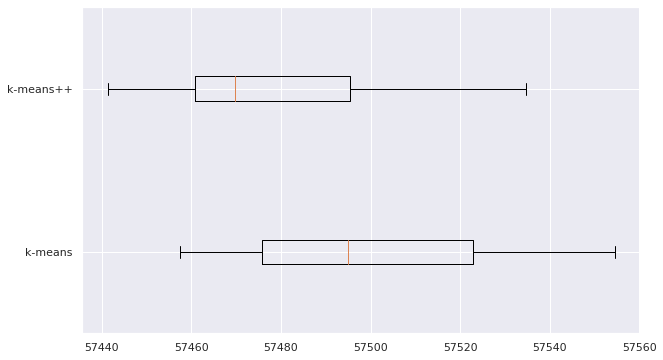

In [32]:
plt.figure(figsize=(10,6))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++']);

## Choosing *k* value

Run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.

In [0]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=400,
                                               record_heterogeneity=None, verbose=False)
        
        # Compute heterogeneity only once in the end
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            
        # update the minimum if current measurement of heterogeneity is lower than before
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity
    return final_centroids, final_cluster_assignment

Try for different values of `k` and `seed`

In [34]:
centroids = {}
cluster_assignment = {}
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]
seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

for k in k_list:
    print(f"k={k}")
    heterogeneity = []
    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                              num_runs=len(seed_list),
                                                              seed_list=seed_list,
                                                              verbose=True)
    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
    heterogeneity_values.append(score)

k=2
seed=000000, heterogeneity=58224.59913
seed=020000, heterogeneity=58179.57453
seed=040000, heterogeneity=58179.57453
seed=060000, heterogeneity=58179.57453
seed=080000, heterogeneity=58224.59952
seed=100000, heterogeneity=58179.57453
seed=120000, heterogeneity=58179.57453
k=10
seed=000000, heterogeneity=57441.33298
seed=020000, heterogeneity=57457.50383
seed=040000, heterogeneity=57469.82237
seed=060000, heterogeneity=57503.05355
seed=080000, heterogeneity=57464.05684
seed=100000, heterogeneity=57487.57010
seed=120000, heterogeneity=57534.79120
k=25
seed=000000, heterogeneity=56828.55406
seed=020000, heterogeneity=56943.91794
seed=040000, heterogeneity=56816.94257
seed=060000, heterogeneity=56920.95767
seed=080000, heterogeneity=56884.99112
seed=100000, heterogeneity=56875.89487
seed=120000, heterogeneity=56911.66467
k=50
seed=000000, heterogeneity=56339.57044
seed=020000, heterogeneity=56351.77299
seed=040000, heterogeneity=56299.53728
seed=060000, heterogeneity=56324.49665
seed=0

In [0]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
   plt.figure(figsize=(10,6))
   plt.plot(k_values, heterogeneity_values, linewidth=2)
   plt.xlabel('k')
   plt.ylabel('heterogeneity')
   plt.title('k vs. heterogeneity')

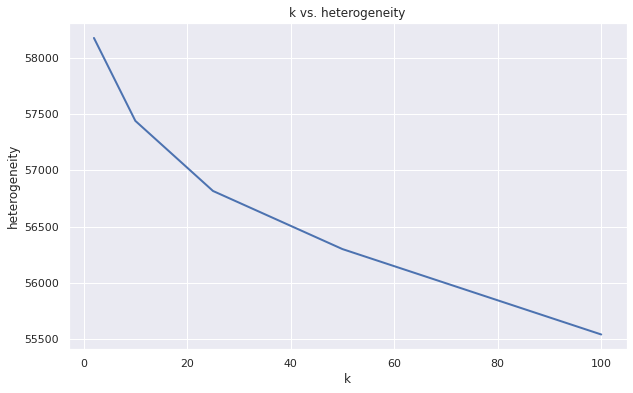

In [36]:
plot_k_vs_heterogeneity(k_list, heterogeneity_values)

We usually choose the eblow point as the best value of *k*.

## Visualizing  clusters of documents

In [0]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    print('==========================================================')

    for c in range(k):
        print("CLUSTER", c)        
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5):
            print(f"{list(map_index_to_word.keys())[list(map_index_to_word.values()).index(idx[i])]}:{round(centroids[c,idx[i]]*100, 2)}%", end = " | ")

        if display_content:
            print("\n")
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()

            # Print top 5 articles
            for i in range(5):
                text = wiki[wiki.index == nearest_neighbors[i]]['text']
                print(f"{wiki[wiki.index == nearest_neighbors[i]]['name'].item()} [{round(distances[nearest_neighbors[i]], 3)}] \n    {text.item()[:300]}") # text limit to 300
        print('\n=================================================================')

In [43]:
k=25
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=True)

CLUSTER 0
album:5.5% | band:4.61% | music:4.23% | released:2.9% | jazz:2.4% | 

Tony Mills (musician) [0.952] 
    tony mills born 7 july 1962 in solihull england is an english rock singer best known for his work with shy and tnthailing from birmingham when he was 14 years old he sang in his first band the punk band the ripoffs before joining fellow birmingham punk band cracked actors as bass guitarist turning t
Will.i.am [0.953] 
    william adams born march 15 1975 known by his stage name william pronounced will i am is an american rapper songwriter entrepreneur actor dj record producer and philanthropist he is best known as a founding member of the hip hoppop band the black eyed peas with whom he has received seven grammy awar
Keith Urban [0.953] 
    keith lionel urban born 26 october 1967 is a new zealand born australian country music singer songwriter guitarist entrepreneur and music competition judge in 1991 he released a selftitled debut album and charted four singles in austra

In [39]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)

CLUSTER 0
brazilian:13.52% | brazil:8.27% | de:5.73% | rio:5.09% | paulo:5.05% | 
CLUSTER 1
film:18.27% | festival:5.35% | films:5.2% | documentary:3.73% | directed:3.58% | 
CLUSTER 2
comics:19.67% | comic:12.3% | strip:3.84% | graphic:3.67% | book:3.43% | 
CLUSTER 3
mayor:14.18% | city:4.73% | council:3.69% | elected:3.23% | election:2.83% | 
CLUSTER 4
tour:25.78% | pga:21.48% | golf:13.96% | open:7.32% | golfer:6.25% | 
CLUSTER 5
band:11.09% | album:4.83% | bands:3.24% | rock:3.18% | guitar:3.13% | 
CLUSTER 6
football:12.03% | afl:11.27% | australian:8.27% | season:5.82% | club:5.77% | 
CLUSTER 7
cricket:19.41% | firstclass:11.38% | cricketer:7.36% | batsman:6.82% | wickets:6.08% | 
CLUSTER 8
physics:18.1% | quantum:6.39% | theoretical:4.86% | theory:4.16% | research:4.12% | 
CLUSTER 9
editor:5.18% | journalism:4.17% | journalist:3.53% | news:3.1% | times:3.0% | 
CLUSTER 10
history:5.41% | university:4.25% | studies:3.86% | professor:3.71% | research:2.51% | 
CLUSTER 11
rugby:21.9% |